## A First Organic Agent in RecoGym

This far in the course you have used standard datasets in order to model user preferences.  These datasets contained information about user preferences, but they were not logs of an actual recommender system.

In this part of the course we will move beyond what is possible using standard datasets of user preferences and we will simmulate a recommender system using the RecoGym environment.

As a first exercise we will consider how to build a first recommender systems using embeddings like the ones we previously computed (in this case we will use SVD embeddings).


A recommender system is typically built up from components.

1. a) We observe behaviour from the user unrelated to the recommender system.  We use this information to produce a user representation, for example we can use feature engineering to turn their history into a fixed length user vector.

1. b) It is often the case that in this part of the model we will build a model of the next item that the user will view - this can help "seed" recommendation models.

2. We observe logs of the recommender system in action.  For example we observe the recommender system delivering recommendations and the user either clicking or not clicking on them.

Most of the work considered so far has been on 1 a) and 1 b).  In this notebook we will complete this part of the journey i.e. 1 a) and 1 b) we will use the RecoGym environment to build SVD embeddings of users, we will then use an organic next item prediction as a recommendation.  In this notebook we will not use logs of the recommender system for refining the recommender system, but we will use simulated recommender system logs to evaluate the performance both offline using the Inverse Propensity Score (IPS) and simmulating an actual AB test.


Actually training on the recommender system logs (also known as bandit feedback) i.e. component 2) is the subject of the next notebook.


In [193]:
%matplotlib inline
import numpy as np
from numpy.random.mtrand import RandomState
from reco_gym import Configuration
from agents import Agent
from scipy.misc import logsumexp
import pandas as pd
from scipy.stats.distributions import beta
from copy import deepcopy
from agents import OrganicUserEventCounterAgent, organic_user_count_args
from reco_gym.envs.session import OrganicSessions
from reco_gym.envs.context import DefaultContext
from reco_gym.envs.observation import Observation
from agents import RandomAgent, random_args



import pylab

from keras.utils import to_categorical
import gym, reco_gym
import numpy as np
# env_0_args is a dictionary of default parameters (i.e. number of products)
from reco_gym import env_1_args, Configuration

P=1000 # Number of Products
U = 2000 # Number of Users


# You can overwrite environment arguments here:
env_1_args['random_seed'] = 42
env_1_args['num_products']= P
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=0
env_1_args['sigma_mu_organic'] = 0.0
env_1_args['sigma_omega']=0
# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

env.reset()

In [194]:
pylab.rcParams['figure.figsize'] = 7, 7

In [195]:
organic_counter_agent = OrganicUserEventCounterAgent(Configuration({
            **organic_user_count_args,
            **env_1_args,
            'select_randomly': True,
        }))

In [196]:
reco_log = env.generate_logs(U, agent=organic_counter_agent)
#reco_log = env.generate_logs(U)
reco_log

,a,c,ps,ps-a,t,u,v,z
0,NaN,NaN,NaN,None,0,0,463.0,organic
1,463.0,0.0,1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,NaN,bandit
2,463.0,0.0,1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0,NaN,bandit
3,NaN,NaN,NaN,None,3,0,1.0,organic
4,NaN,NaN,NaN,None,4,0,1.0,organic
5,NaN,NaN,NaN,None,5,0,1.0,organic
6,NaN,NaN,NaN,None,6,0,802.0,organic
7,NaN,NaN,NaN,None,7,0,1.0,organic
8,NaN,NaN,NaN,None,8,0,1.0,organic
9,NaN,NaN,NaN,None,9,0,477.0,organic


In [197]:
organic_reco_log = reco_log[reco_log['z']=='organic']

counts = np.zeros((U,P))

for u in range(U):
    counts[u,:] = to_categorical(np.array(organic_reco_log[organic_reco_log['u']==u].v,dtype=int),P).sum(0)

# counts ignores time, but otherwise produces a representation of the users interests    
# you can either factorize counts directly or instead look at the co_counts i.e.
counts[0,:]

array([0., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [198]:
counts_above_zero = 1.*(counts>0) # above zero counts only

co_counts = np.matmul(counts_above_zero.T,counts_above_zero)

In [199]:
# a product might be summarised by the P length vector of its co-counts, e.g. for product 0
co_counts[0,:]

array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  3.,  0.,  0.,  0.,
        0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0

this methodology works, but it doesn't scale..  at Criteo we have one billion products.. try re-running the above with just a 1000 - the user vecotors become long and sparse and the co-counts matrix is also very sparse.  We can determine similarities only between the most popular products.  In order to make the product embeddings both much shorter than P and not sparse we can use matrix factorization models.  You can either factorize the count matrix above or the co_counts matrix.

In [200]:
w,v = np.linalg.eig(co_counts)
idx = np.argsort(w)[::-1] 
v=np.real(v[:,idx])
w=np.real(w[idx])

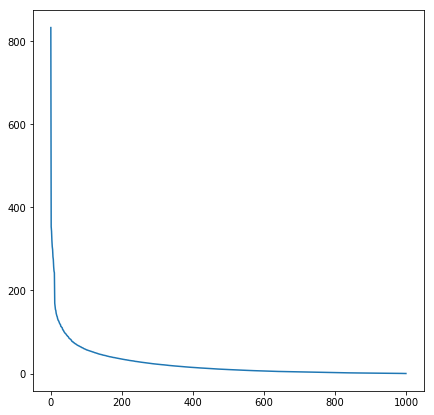

In [201]:
pylab.plot(w)

In [202]:
wdash = np.zeros_like(w)
K=5
wdash[0:K] = w[0:K]
embeddings = np.matmul(v,np.sqrt(np.diag(wdash)))[:,0:K] # keep the non-zero combonents

In [203]:
root=15
vvmax = ((np.matmul(embeddings,embeddings.T))).max()**(1/root)

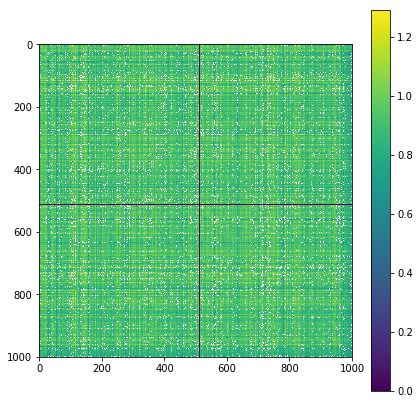

In [204]:
pylab.imshow((np.matmul(embeddings,embeddings.T))**(1/root),vmin=0,vmax=vvmax)
pylab.colorbar()

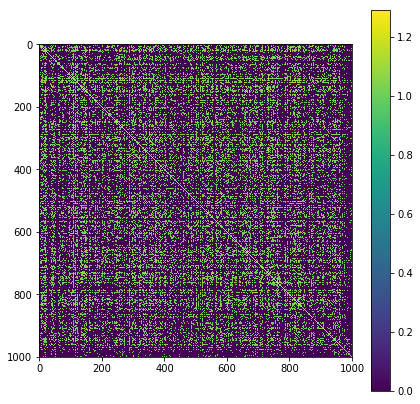

In [205]:
pylab.imshow((co_counts)**(1/root),vmin=0,vmax=vvmax)
pylab.colorbar()

the reason that the eigenvalue decomp is more full is that due to being a low-rank approximation it will be able to use logic such as if prodocut 0 is related to product 1 and product 1 is related to product 2 then product 0 is related to product 2

Text(0,0.5,'log embedding dot product')

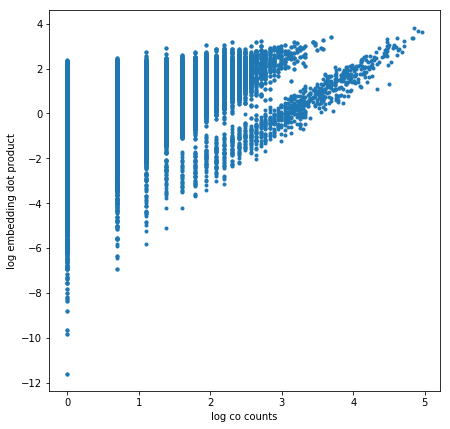

In [206]:
pylab.plot(np.log(co_counts.flatten()),np.log((np.matmul(embeddings,embeddings.T)).flatten()),'.')
pylab.xlabel('log co counts')
pylab.ylabel('log embedding dot product')

## An organic SVD agent

Below we have an organic SVD agent.  This agent is trained on an offline log of organic user events in the same way as above - we place this code in the create_embeddings function.  We then define the AgentFromLog class which takes an organic reco log and produces the embedding.  It then is deployed in a real system.  When an agent receives events we create a user embedding by averaging the product embedding of all the items the user saw.  When the agent is called upon to act (the act method) it computes a dot product of each product embedding with the product embedding corresponding to each possible recommendation with high probability the highest of these is selected.

In [207]:
def create_embeddings(reco_log, K=5):
    organic_reco_log = reco_log[reco_log['z']=='organic']
    counts = np.zeros((U,P))

    for u in range(U):
        counts[u,:] = to_categorical(np.array(organic_reco_log[organic_reco_log['u']==u].v,dtype=int),P).sum(0)

    counts_above_zero = 1.*(counts>0) # above zero counts only
    co_counts = np.matmul(counts_above_zero.T,counts_above_zero)

    wdash = np.zeros_like(w)

    wdash[0:K] = w[0:K]
    embeddings = np.matmul(v,np.sqrt(np.diag(wdash)))[:,0:K] # keep the non-zero combonents        
    return embeddings

class AgentFromLog(Agent):
    def __init__(self, config, reco_log, K=5):
        super(AgentFromLog, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.organic_views = np.zeros(self.config.num_products)
        self.embeddings = create_embeddings(reco_log, K)
        self.K = K
        self.history_length = 0
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_embedding += self.embeddings[session['v'],:]
            self.history_length += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        uprob = np.matmul(self.embeddings,self.user_embedding/self.history_length)
        prob = np.exp(uprob-logsumexp(uprob))
        action = self.rng.choice(self.config.num_products, p = prob)
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_embedding = np.zeros(self.K)
        self.history_length = 0

In [208]:
embedding_agent5  = AgentFromLog(Configuration(env_1_args), reco_log,  5)
embedding_agent20 = AgentFromLog(Configuration(env_1_args), reco_log, 20)
embedding_agent50 = AgentFromLog(Configuration(env_1_args), reco_log, 50)
embedding_agent100 = AgentFromLog(Configuration(env_1_args), reco_log, 100)




random_args['num_products'] = P
agent_rand = RandomAgent(Configuration({**env_1_args, **random_args,}))

## Offline evaluation


All of the above is quite recognisable from earlier parts of the course, but now here things differ.  We use the offline logs to do an offline evaluation.  This is an unbiassed estimate of how the algorithm will perform when we deploy it.  In order to do this we use what is known as an Inverse Propensity Score estimator.

The basis of this idea is that we have an offline log of a randomised policy (i.e. a policy that uses some level of randomness to choose actions, although it typically chooses good actions).  We then develop a new policy.  We use the log of the probability of past actions in order to adjust the new policy so that if it deploys an action more often we increase the weighting of that component and if it deploys an action less often we downweight the expected number of clicks as attributed to that action.


In [209]:
def evaluate_IPS(agent, reco_log):
    ee = []
    for u in range(max(reco_log.u)):
        t = np.array(reco_log[reco_log['u']==u].t)
        v = np.array(reco_log[reco_log['u']==u].v)
        a = np.array(reco_log[reco_log['u']==u].a)
        c = np.array(reco_log[reco_log['u']==u].c)
        z = list(reco_log[reco_log['u']==u].z)
        ps = np.array(reco_log[reco_log['u']==u].ps)

        jj=0
        
        session = OrganicSessions()
        agent.reset()
        while True:
            if jj >= len(z):
                break
            if z[jj] == 'organic':
                session.next(DefaultContext(t[jj],u), int(v[jj]))
            else:
                prob_policy = agent.act(Observation(DefaultContext(t[jj],u), session), 0, False)['ps-a']
                ee.append(c[jj] * prob_policy[int(a[jj])] / ps[jj])
                session = OrganicSessions()
            jj += 1
    return ee

In [210]:
def verify_agents_IPS(reco_log, agents):
    stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    for agent_id in agents:
        ee = evaluate_IPS(agents[agent_id], reco_log)
        mean_ee = np.mean(ee)
        se_ee = np.std(ee)/np.sqrt(len(ee))
        stat['Agent'].append(agent_id)
        stat['0.025'].append(mean_ee - 2*se_ee)
        stat['0.500'].append(mean_ee)
        stat['0.975'].append(mean_ee + 2*se_ee)
    return pd.DataFrame().from_dict(stat)

In [211]:
verify_agents_IPS(reco_log, {'embedding_agent5': embedding_agent5, 'embedding_agent20': embedding_agent20, 'embedding_agent50': embedding_agent50,  'embedding_agent100': embedding_agent100, 'organic counter': organic_counter_agent, 'agent_rand': agent_rand})

,0.025,0.500,0.975,Agent
0,0.007438,0.008333,0.009228,embedding_agent5
1,0.015925,0.017456,0.018986,embedding_agent20
2,0.020322,0.021977,0.023632,embedding_agent50
3,0.021734,0.023368,0.025003,embedding_agent100
4,0.022038,0.022806,0.023574,organic counter
5,0.000242,0.000257,0.000272,agent_rand


## The IPS Results

IPS while powerful is often too noisy to rank agent performance.  This is especially the case if the serrendipidous agreement between the old and the new policy is rare.  In this case variance can be very high.

There may be no alterantive to actually deploy an algorithm in production i.e. run an AB test.  This is usually done subject to reasonable offline metrics as it is usually costly and time consuming to perform.

In [212]:
def verify_agents(env, number_of_users, agents):
    stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    for agent_id in agents:
        stat['Agent'].append(agent_id)
        data = deepcopy(env).generate_logs(number_of_users, agents[agent_id])
        bandits = data[data['z'] == 'bandit']
        successes = bandits[bandits['c'] == 1].shape[0]
        failures = bandits[bandits['c'] == 0].shape[0]
        stat['0.025'].append(beta.ppf(0.025, successes + 1, failures + 1))
        stat['0.500'].append(beta.ppf(0.500, successes + 1, failures + 1))
        stat['0.975'].append(beta.ppf(0.975, successes + 1, failures + 1))
        
    return pd.DataFrame().from_dict(stat)

In [213]:
verify_agents(env, U, {'embedding_agent5': embedding_agent5, 'embedding_agent20': embedding_agent20, 'embedding_agent50': embedding_agent50,  'embedding_agent100': embedding_agent100, 'organic counter': organic_counter_agent, 'agent_rand': agent_rand})

,0.025,0.500,0.975,Agent
0,0.016973,0.017613,0.018269,embedding_agent5
1,0.021783,0.022509,0.023251,embedding_agent20
2,0.022911,0.023655,0.024415,embedding_agent50
3,0.023275,0.024025,0.024791,embedding_agent100
4,0.021806,0.022533,0.023276,organic counter
5,0.009895,0.010382,0.010884,agent_rand


## Simulated AB Test results

While the IPS test results were too noisy to order the performance of the agents we find that we have much less uncertainty when we simulate an AB test.